Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Denoising Diffusion Probabilistic Models with MedNIST Dataset

This tutorial compares the different schedulers available for sampling from a trained model with a reduced number of timesteps. The schedulers we will compare are:

[1] - DDPM - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

[2] - DDIM - Song et al. "Denoising Diffusion Implicit Models" https://arxiv.org/abs/2010.02502

[3] - PNDM - Liu et al. "Pseudo Numerical Methods for Diffusion Models on Manifolds" https://arxiv.org/abs/2202.09778



## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDIMScheduler, DDPMScheduler, PNDMScheduler

print_config()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.4.0rc6
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6a0e1b043ba2890e1463fa49df76f66e56a68b08
MONAI __file__: /home/<username>/miniconda3/envs/monai/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.14.0
pynrrd version: 1.0.0
clearml version: 1.16.2rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpm4jzl5xr


## Set deterministic training for reproducibility

In [3]:
set_determinism(0)

## Setup MedNIST Dataset and training and validation dataloaders
In this tutorial, we will train our models on the MedNIST dataset available on MONAI
(https://docs.monai.io/en/stable/apps.html#monai.apps.MedNISTDataset). In order to train faster, we will select just
one of the available classes ("Hand"), resulting in a training set with 7999 2D images.

In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
batch_size = 64
num_workers = 4

Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[64, 64],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True
)

Loading dataset: 100%|██████████| 7999/7999 [00:05<00:00, 1354.84it/s]


In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

2024-09-02 18:24:30,579 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-09-02 18:24:30,580 - INFO - File exists: /tmp/tmpm4jzl5xr/MedNIST.tar.gz, skipped downloading.
2024-09-02 18:24:30,581 - INFO - Non-empty folder exists in /tmp/tmpm4jzl5xr/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 1005/1005 [00:00<00:00, 1390.42it/s]


### Visualisation of the training images

batch shape: torch.Size([128, 1, 64, 64])


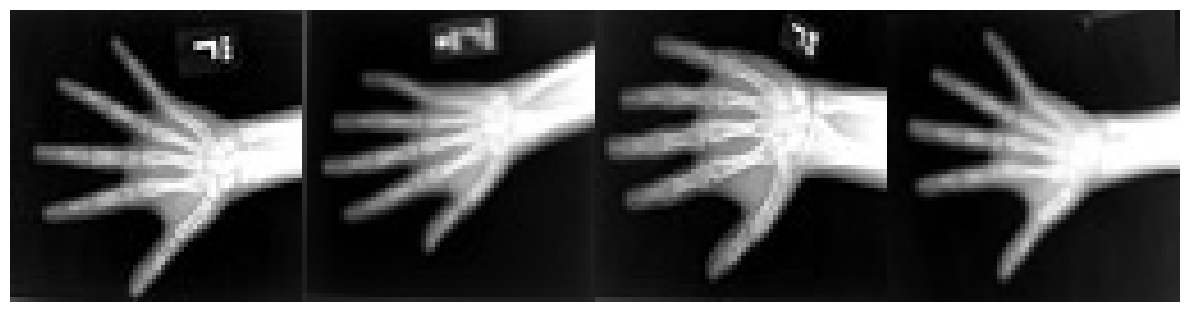

In [8]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network and optimizer
At this step, we instantiate the MONAI components to create a DDPM, a 2D unet with attention mechanisms
in the 2nd and 4th levels, each with 1 attention head.

In [9]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=128,
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), 2.5e-5)

### Define schedulers

We use a DDPM scheduler with 1000 steps for training. For sampling, we will compare the DDPM, DDIM, and PNDM.

In [10]:
num_train_timesteps = 1000
ddpm_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps)
ddim_scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)
pndm_scheduler = PNDMScheduler(num_train_timesteps=num_train_timesteps, skip_prk_steps=True)

# the range of sampling steps we want to use when testing the DDIM and PNDM schedulers
sampling_steps = [1000, 500, 200, 50]

### Define inferer for sampling

In [11]:
inferer = DiffusionInferer(scheduler=ddpm_scheduler)

### Model training
Here, we are training our model for 100 epochs (training time: ~40 minutes). It is necessary to train for a bit longer than other tutorials because the DDIM and PNDM schedules seem to require a model trained longer before they start producing good samples, when compared to DDPM.

If you would like to skip the training and use a pre-trained model instead, set `use_pretrained=True`. This model was trained using the code in `tutorials/generative/distributed_training/ddpm_training_ddp.py`

Epoch 9: 100%|██████████| 63/63 [00:21<00:00,  2.94it/s, loss=0.0596]
...


100%|██████████| 50/50 [00:00<00:00, 103.02it/s]


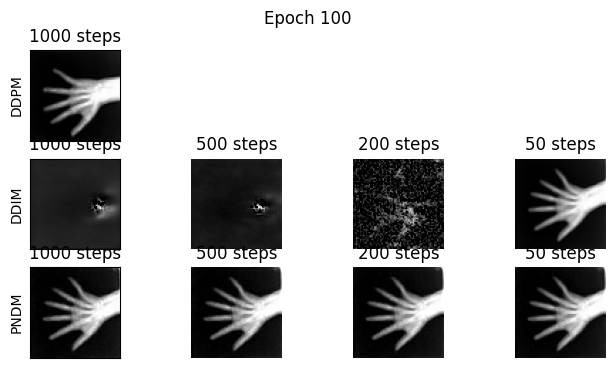

In [12]:
use_pretrained = False

if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    max_epochs = 100
    val_interval = 10
    epoch_loss_list = []
    val_epoch_loss_list = []
    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"].to(device)
            optimizer.zero_grad(set_to_none=True)

            # Randomly select the timesteps to be used for the minibacth
            timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=device).long()

            # Add noise to the minibatch images with intensity defined by the scheduler and timesteps
            noise = torch.randn_like(images).to(device)
            noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)

            # In this example, we are parametrising our DDPM to learn the added noise (epsilon).
            # For this reason, we are using our network to predict the added noise and then using L1 loss to predict
            # its performance.
            noise_pred = model(x=noisy_image, timesteps=timesteps)
            loss = F.l1_loss(noise_pred.float(), noise.float())

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            progress_bar = tqdm(enumerate(val_loader), total=len(train_loader))
            progress_bar.set_description(f"Epoch {epoch} - Validation set")
            for step, batch in progress_bar:
                images = batch["image"].to(device)
                timesteps = torch.randint(0, num_train_timesteps, (images.shape[0],), device=device).long()
                noise = torch.randn_like(images).to(device)
                with torch.no_grad():
                    noisy_image = ddpm_scheduler.add_noise(original_samples=images, noise=noise, timesteps=timesteps)
                    noise_pred = model(x=noisy_image, timesteps=timesteps)
                    val_loss = F.l1_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddpm_scheduler)
            plt.figure(figsize=(8, 4))
            plt.subplot(3, len(sampling_steps), 1)
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            plt.ylabel("DDPM")
            plt.title("1000 steps")
            # DDIM
            for idx, reduced_sampling_steps in enumerate(sampling_steps):
                ddim_scheduler.set_timesteps(reduced_sampling_steps)
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddim_scheduler)
                plt.subplot(3, len(sampling_steps), len(sampling_steps) + idx + 1)
                plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
                plt.ylabel("DDIM")
                if idx == 0:
                    plt.tick_params(
                        top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
                    )
                else:
                    plt.axis("off")
                plt.title(f"{reduced_sampling_steps} steps")
            # PNDM
            for idx, reduced_sampling_steps in enumerate(sampling_steps):
                pndm_scheduler.set_timesteps(reduced_sampling_steps)
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=pndm_scheduler)
                plt.subplot(3, len(sampling_steps), len(sampling_steps) * 2 + idx + 1)
                plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
                plt.ylabel("PNDM")
                if idx == 0:
                    plt.tick_params(
                        top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False
                    )
                else:
                    plt.axis("off")
                plt.title(f"{reduced_sampling_steps} steps")
            plt.suptitle(f"Epoch {epoch+1}")
            plt.show()

### Learning curves

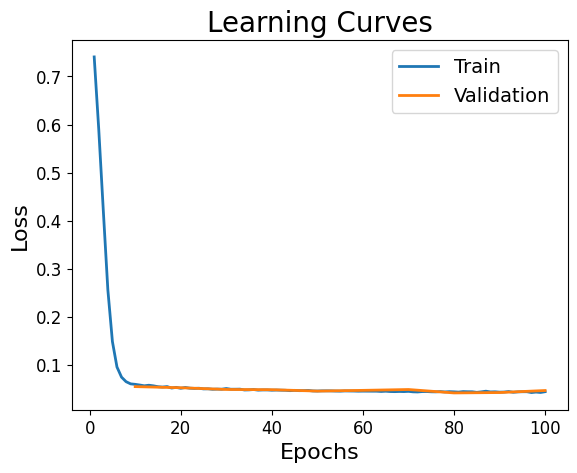

In [16]:
if not use_pretrained:
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

### Compare samples from trained model

100%|██████████| 50/50 [00:00<00:00, 104.01it/s]


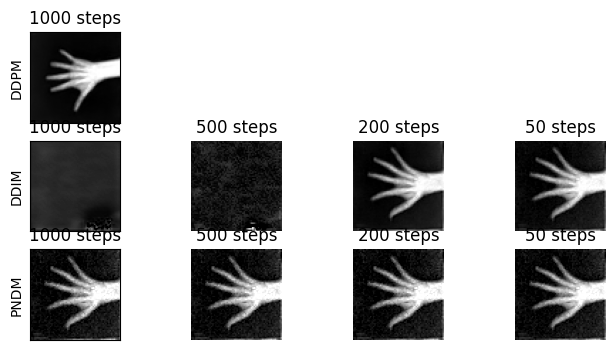

In [17]:
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddpm_scheduler)
plt.figure(figsize=(8, 4))
plt.subplot(3, len(sampling_steps), 1)
plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.ylabel("DDPM")
plt.title("1000 steps")
# DDIM
for idx, reduced_sampling_steps in enumerate(sampling_steps):
    ddim_scheduler.set_timesteps(reduced_sampling_steps)
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=ddim_scheduler)
    plt.subplot(3, len(sampling_steps), len(sampling_steps) + idx + 1)
    plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.ylabel("DDIM")
    if idx == 0:
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    else:
        plt.axis("off")
    plt.title(f"{reduced_sampling_steps} steps")
# PNDM
for idx, reduced_sampling_steps in enumerate(sampling_steps):
    pndm_scheduler.set_timesteps(reduced_sampling_steps)
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=pndm_scheduler)
    plt.subplot(3, len(sampling_steps), len(sampling_steps) * 2 + idx + 1)
    plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.ylabel("PNDM")
    if idx == 0:
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    else:
        plt.axis("off")
    plt.title(f"{reduced_sampling_steps} steps")
plt.show()

### Cleanup data directory
Remove directory if a temporary was used

In [18]:
if directory is None:
    shutil.rmtree(root_dir)